# WWW Experiements

Here we try to do some additional experiments for evaluating and comparing to other approaches.

#### Story #1

Do a tf-idf on the hate community data set and show what terms the most important terms and compare with our code words output. The last paper I sent you, they have a table where they show the top 10 correlated code words. So I'm thinking of that as one direct comparison. Heavily emphasize the drawback of the 5 manual code words.

#### Story #3

We have the list of twitter IDs from the hate community, the other paper mentions that they looked for people who tweeted on of their code words > 4 times as a way to say that these were 'hate users'. What if we use the list of Twitter IDs to check and see how many of our user accounts were banned from Twitter? As a way to say that we identified these users as being a part of this community, and in the time since the data was collected to now, these are the number of users that were reported and had their accounts blocked. Showing that we did in fact find a hate community. Talk about how all the research applies the same techniques and that it comes down to the quality of the data used. I think an interim solution is to heavily emphasis the need for good hate speech data from these communities. And highlight that issue by citing a paper that spoke about the difference in classification scores when using amateur vs expert data.


#### Story #4

We keep mentioning how that the data collection method and code word process would be good for downstream use like classification or annotation. I think it would be good to focus on the difference in the types of samples I got when I took sentences from the 3 different data sets for the survey. In that way, we can say that if an annotation task were to be done with data collected via keywords, it wouldn't lead to quality results. And we back that up with the annotator agreement scores. The scores are currently there but that distinction isn't higlighted.

In [1]:
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os, joblib
from collections import OrderedDict
from pprint import pprint
import numpy as np
from itertools import islice
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from modules.utils import file_ops, settings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [27]:
def build_word_cloud(frequency):
    word_cloud = WordCloud(background_color="white", width=1920, height=1080).generate_from_frequencies(frequency)
    return word_cloud

def build_inverse_frequecy(frequency):
    inversed_frequency = {key:1/value for key, value in frequency.items()}
    return inversed_frequency

#### Load hate community data

In [4]:
# connection_params_1 = ["twitter", "melvyn_hs_users"]
# connection_params_2 = ["dailystormer_archive", "d_stormer_documents"]

# df_melvyn = model_helpers.fetch_as_df(connection_params_1, {"preprocessed_txt": 1})
# df_dstormer = model_helpers.fetch_as_df(connection_params_2, {"preprocessed_txt": 1})

# joblib.dump(df_melvyn, settings.DATASET_PATH + 'hs_users.plk.compressed' , compress=True)
# joblib.dump(df_dstormer, settings.DATASET_PATH + 'dstormer.plk.compressed', compress=True)

df_melvyn = joblib.load(settings.DATASET_PATH + 'hs_users.plk.compressed')
df_dstormer = joblib.load(settings.DATASET_PATH + 'dstormer.plk.compressed')
df_hate_corpus = pd.concat([df_melvyn, df_dstormer])

#### Load code words 

In [5]:
hs_keywords = set(file_ops.read_csv_file("refined_hs_keywords", settings.TWITTER_SEARCH_PATH))
df_primary = pd.read_csv(settings.CW_SEARCH_PATH + "primary_cw_search_results.csv")
df_secondary = pd.read_csv(settings.CW_SEARCH_PATH + "secondary_cw_search_results.csv")
primary_set = set(df_primary['primary'].tolist())
secondary_set = set(df_secondary['secondary'].tolist())
codeword_set = primary_set.union(secondary_set)

### Story #1
[example](http://www.ultravioletanalytics.com/2016/11/18/tf-idf-basics-with-pandas-scikit-learn/)

#### Calculate tf-idf scores

In [6]:
cvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,1))
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english', ngram_range=(1,1))

In [7]:
hate_corpus_tvec_weights = tvec.fit_transform(df_hate_corpus.preprocessed_txt.dropna())
hate_corpus_weights = np.asarray(hate_corpus_tvec_weights.mean(axis=0)).ravel().tolist()
hate_corpus_weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': hate_corpus_weights})

In [8]:
hate_corpus_weights_df.sort_values(by="weight", ascending=False, inplace=True)
hate_corpus_weights_df = hate_corpus_weights_df.reset_index(drop=True)

In [9]:
mv_tvec_weights = tvec.fit_transform(df_melvyn.preprocessed_txt.dropna())
mv_weights = np.asarray(mv_tvec_weights.mean(axis=0)).ravel().tolist()
mv_weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': mv_weights})
# mv_weights_df.sort_values(by='weight', ascending=False).head(10)

In [10]:
ds_tvec_weights = tvec.fit_transform(df_dstormer.preprocessed_txt.dropna())
ds_weights = np.asarray(ds_tvec_weights.mean(axis=0)).ravel().tolist()
ds_weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': ds_weights})
# ds_weights_df.sort_values(by='weight', ascending=False).head(10)

In [11]:
hate_corpus_set = set(hate_corpus_weights_df['term'].tolist())
mv_set = set(mv_weights_df['term'].tolist())
ds_set = set(ds_weights_df['term'].tolist())

#### Retrieve code word idf scores

In [12]:
ds_candidate_codewords_v2 = file_ops.read_json_file("ds_candidate_codewords_v2", settings.CW_SEARCH_PATH)
mhs_candidate_codewords_v2 = file_ops.read_json_file("mhs_candidate_codewords_v2", settings.CW_SEARCH_PATH)
hate_corpus_codewords = {**ds_candidate_codewords_v2, **mhs_candidate_codewords_v2}
hate_corpus_idf = {word:hate_corpus_codewords[word]["idf_biased"][0] for word in hate_corpus_codewords}

In [13]:
df_hate_corpus_idf = pd.DataFrame(list(hate_corpus_idf.items()),columns=['word','weight'])
# df_hate_corpus_idf_reverse = df_hate_corpus_idf
# df_hate_corpus_idf_reverse.sort_values(by="weight", ascending=False, inplace=True)
df_hate_corpus_idf.sort_values(by="weight", ascending=True, inplace=True)
df_hate_corpus_idf = df_hate_corpus_idf.reset_index(drop=True)
# df_hate_corpus_idf_reverse = df_hate_corpus_idf_reverse.reset_index(drop=True)

In [14]:
df_hate_corpus_idf.loc[df_hate_corpus_idf['word'] == "cucks"]

,word,weight
11,cucks,2.8703


#### Compare rank

In [15]:
# df_hate_corpus_idf_reverse.head(15)

In [16]:
df_hate_corpus_idf.head(15)

,word,weight
0,wrong,2.113583
1,muslims,2.143791
2,liberals,2.400760
3,cuck,2.607682
4,illegals,2.622941
5,dems,2.638181
6,crazy,2.720823
7,leftists,2.748806
8,globalist,2.780307
9,male,2.795717


In [17]:
hate_corpus_weights_df.head(15)

,term,weight
0,trump,0.018984
1,people,0.016778
2,white,0.016046
3,like,0.015998
4,just,0.015526
5,don,0.012965
6,good,0.011086
7,right,0.011032
8,new,0.009179
9,know,0.008953


#### Visualize wordcloud

In [18]:
tfidf_keys = hate_corpus_weights_df['term'].tolist()
tfidf_weights = hate_corpus_weights_df['weight'].tolist()

idf_keys = df_hate_corpus_idf['word'].tolist()
idf_weights = df_hate_corpus_idf['weight'].tolist()

In [19]:
tfidf_dict = {}
idf_dict = {}
for k, v in zip(tfidf_keys, tfidf_weights):
    tfidf_dict[k] = v
    
for k, v in zip(idf_keys, idf_weights):
    idf_dict[k] = v

#### TF-IDF Plot

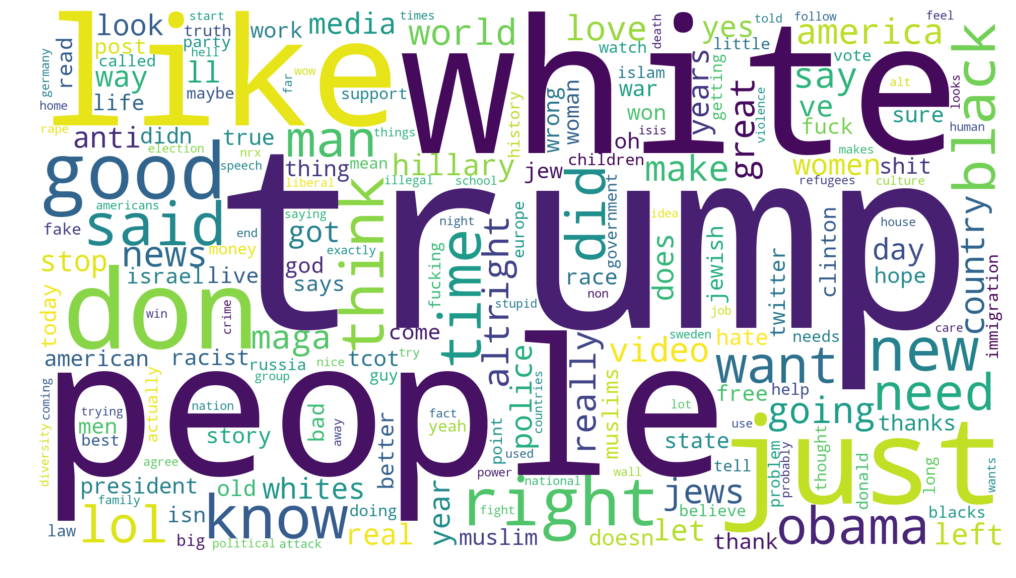

In [32]:
tfidf_word_cloud = build_word_cloud(tfidf_dict)
fig1 = plt.figure( figsize=(20,10) )
plt.imshow(tfidf_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
fig1.savefig(settings.PLOT_PATH + 'tfidf.pdf', bbox_inches='tight')

#### Code words

In [21]:
del idf_dict["wrong"]

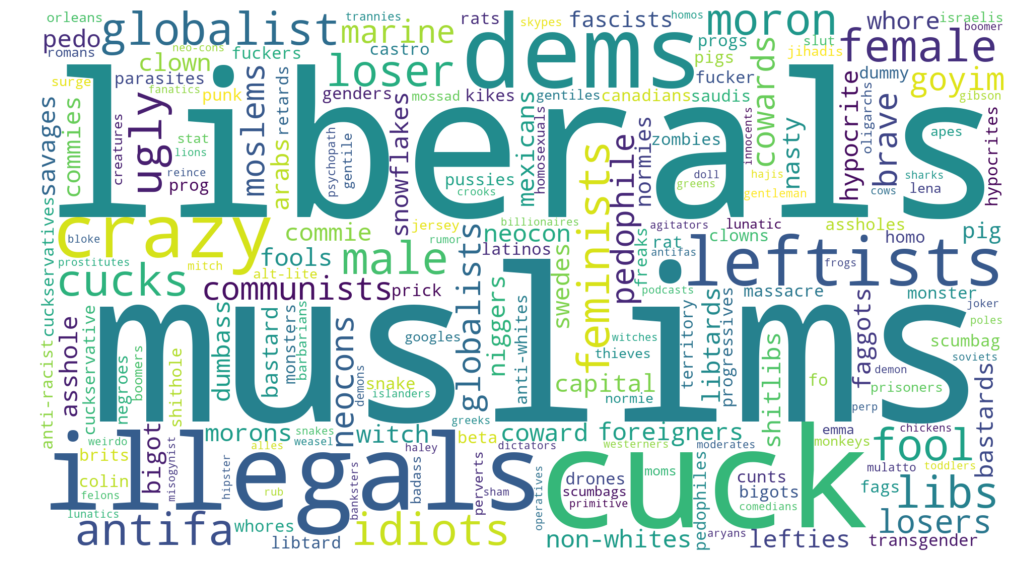

In [33]:
idf_inverse = build_inverse_frequecy(idf_dict)
inv_hate_corpus_word_cloud = build_word_cloud(idf_inverse)
fig2 = plt.figure( figsize=(20,10) )
plt.imshow(inv_hate_corpus_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
fig2.savefig(settings.PLOT_PATH + 'codewords.pdf', bbox_inches='tight')

In [23]:
# hate_corpus_word_cloud = build_word_cloud(idf_dict)
# plt.figure( figsize=(12,12) )
# plt.imshow(hate_corpus_word_cloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

#### Story #3

The following results show that most of the accounts still exist, sot it's not a usable metric.
- Original num ID:  418
- Found count:  353
- Not found count:  47